In [2]:
# these are just basic import statements
import IPython.display as display
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
from tensorflow.python.ops.gen_array_ops import squeeze

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
# converting tensor to images
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
# download content image and style image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [5]:
# function to load image with max 512 pixels dimension
def load_image(path_to_image):
  max_dim=512
  img = tf.io.read_file(path_to_image)
  img = tf.image.decode_image(img, channels=3)  # channels here means color channels - 3 because RGB
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) # not really sure whats happening here, kind of reshaping it to fit?
  long_dim = max(shape)
  scale = max_dim/long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)   # resizing?
  img = img[tf.newaxis, :]
  return img

In [6]:
# just a function to squueze and display the image
def display_image(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis = 0)
  plt.imshow(image)
  if title:
    plt.title(title)

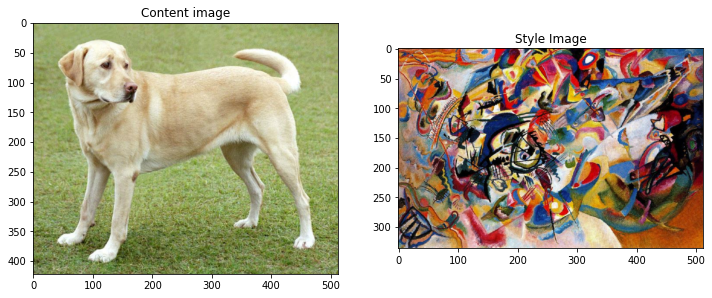

In [7]:
content_image=load_image(content_path)
style_image=load_image(style_path)

plt.subplot(1, 2, 1)
display_image(content_image, 'Content image')

plt.subplot(1, 2, 2)
display_image(style_image, 'Style Image')

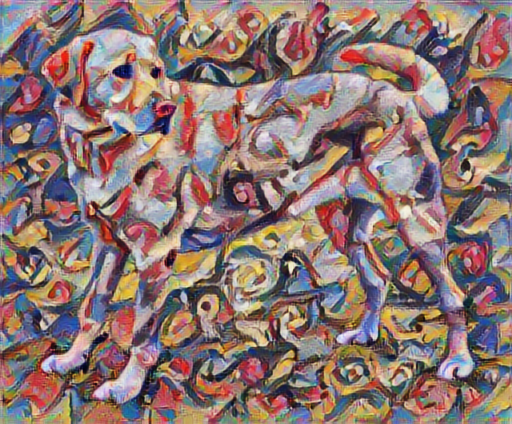

In [8]:
# trying out TensorFlow HUB model

import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# apparently this model is super quick (and partially trained?) -- transfer learning? we didnt unfreeze or retrain on anything
# took 16 seconds
# tbh the dog looks kind of perfect, there is no accomodation of "errors" made by artist? Like i can't copy a dog from a picture perfectly
# if we want to accomodate that, then we kind of WANT there to be some kind of loss/cost between the generated and content images

In [9]:
# loading a VGG19 network and verifying its able to predict our content image: dog

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)

# prediction_probabilities.shape
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
top_5 = {}

for number, class_name, prob in predicted_top_5:
  top_5[class_name] = prob

print(top_5)

49152/35363 [=========================================] - 0s 0us/step
{'Labrador_retriever': 0.49317124, 'golden_retriever': 0.236653, 'kuvasz': 0.036357526, 'Chesapeake_Bay_retriever': 0.024182705, 'Greater_Swiss_Mountain_dog': 0.018646037}


In [10]:
# loading a v99 without classification head
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
# choosing intermediate layers from network to represent the style and content of image 
# need to choose an inbetween layer since something too close to input would be too similar to the content

# VGG is trained to classify images so in the later layers (content) it is able to distinguish complex features
# in the earlier layers it detects things like color contrasts/edges -- good for styles?

content_layers = ['block5_conv2']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

n_content_layers = len(content_layers)
n_style_layers = len(style_layers)

In [12]:
# building our model using VGG pretrained on imagenet data
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = []
  for ly in layer_names:
    outputs.append(vgg.get_layer(ly).output)

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

# Looking at shape, min, max, mean -- maybe this will help us decide which layers provide the best
# stylistic transfer?

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("   shape:  ", output.numpy().shape)
  print("   min:    ", output.numpy().min())
  print("   max:    ", output.numpy().max())
  print("   mean:   ", output.numpy().mean())
  print()


block1_conv1
   shape:   (1, 336, 512, 64)
   min:     0.0
   max:     835.5256
   mean:    33.97525

block2_conv1
   shape:   (1, 168, 256, 128)
   min:     0.0
   max:     4625.887
   mean:    199.82687

block3_conv1
   shape:   (1, 84, 128, 256)
   min:     0.0
   max:     8789.237
   mean:    230.78099

block4_conv1
   shape:   (1, 42, 64, 512)
   min:     0.0
   max:     21566.14
   mean:    791.24005

block5_conv1
   shape:   (1, 21, 32, 512)
   min:     0.0
   max:     3189.2537
   mean:    59.179485



In [14]:
"""
Ok now we are going to calculate the style per layer
What this really means is that lets say at layer l, we have 5 filters, we are going to see how correlated a point (x,y) is at filter k and filter k'
We do that for all points for all filters over all our style layers (as per above, we have 5)

mathematically - it is a gram matrix - outer product of feature vector with itself at each location across all locations
"""

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [15]:
"""
Putting everything together: creating a model that returns style and content tensors
"""
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0055228444
    max:  28014.557
    mean:  263.79025

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.473
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.9766

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320505.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.39
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8772
    mean:  13.764149


In [17]:
# calculating loss + gradient descent

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# we are going to optimize the content image for stylization, so we initialize a variable with the content image
image = tf.Variable(content_image)

# normalizing helper function to keep pixels between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# using Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

# is this the alpha and beta hyperparameters during loss calculation?
style_weight = 1e-2
content_weight = 1e4

# basically the J(G, C) + J(G, S) formula in code
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss *= style_weight / n_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / n_content_layers
    loss = style_loss + content_loss
    return loss

In [18]:
# what does this do?? -- apparently gradient tape keeps track of the error (Which is the gradient) for backpropogration
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  gradient = tape.gradient(loss, image)
  optimizer.apply_gradients([(gradient, image)])
  image.assign(clip_0_1(image))

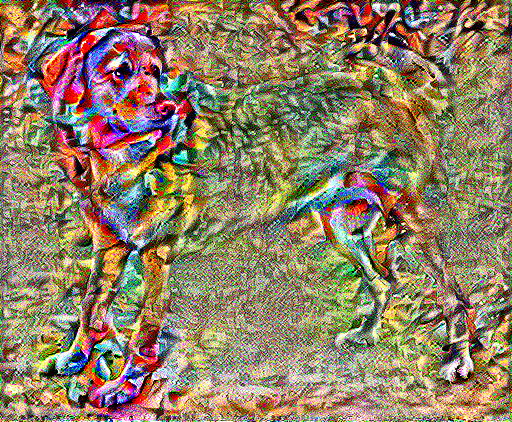

Train step: 200
Total time: 1396.3


In [19]:
# alright lets train us some bad peeps
# kinda want to see whats happening after each training step

starttime = time.time()
epochs = 10
per_epoch = 20

step = 0
for n in range(epochs):
  for m in range(per_epoch):
    step = step + 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-starttime))